In [1]:
# Import necessary packages 
import pandas as pd, numpy as np, sklearn as sk 

## Cleaning Step 1a: Bike Crash Data 
I'm specifically focusing on *protected* bike lanes in this project. Depending on the speed of the surrounding motor vehicles and a number of other factors, *unprotected* bike lanes can severely underperform at achieving cyclist safety. For this reason, I'll only consider recommending cycling infrastructure putting a physical barrier between bikes and cars. 

In [2]:
# Import our data from CSV and take a look! 
df_crashes_raw = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes_20240928.csv")

/var/folders/jm/qn6ndxwn77lfwzzx82qw9_wh0000gn/T/ipykernel_32824/3530167884.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_crashes_raw = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes_20240928.csv")


In [3]:
df_crashes_raw.head()

CRASH_DATE CRASH_TIME   BOROUGH ZIP_CODE   LATITUDE  LONGITUDE  \
0  09/11/2021       2:39       NaN      NaN        NaN        NaN   
1  03/26/2022      11:45       NaN      NaN        NaN        NaN   
2  06/29/2022       6:55       NaN      NaN        NaN        NaN   
3  09/11/2021       9:35  BROOKLYN  11208.0  40.667202 -73.866500   
4  12/14/2021       8:13  BROOKLYN  11233.0  40.683304 -73.917274   

                  LOCATION           ON_STREET_NAME CROSS_STREET_NAME  \
0                      NaN    WHITESTONE EXPRESSWAY         20 AVENUE   
1                      NaN  QUEENSBORO BRIDGE UPPER               NaN   
2                      NaN       THROGS NECK BRIDGE               NaN   
3    (40.667202, -73.8665)                      NaN               NaN   
4  (40.683304, -73.917274)          SARATOGA AVENUE    DECATUR STREET   

           OFF_STREET_NAME  ...  CONTRIBUTING_FACTOR_VEHICLE_2  \
0                      NaN  ...                    Unspecified   
1                      NaN  ...                            NaN   
2                      NaN  ...                    Unspecified   
3  1211      LORING AVENUE  ...                            NaN   
4                      NaN  ...                            NaN   

   CONTRIBUTING_FACTOR_VEHICLE_3  CONTRIBUTING_FACTOR_VEHICLE_4  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   CONTRIBUTING_FACTOR_VEHICLE_5  COLLISION_ID  VEHICLE_TYPE_CODE_1  \
0                            NaN       4455765                Sedan   
1                            NaN       4513547                Sedan   
2                            NaN       4541903                Sedan   
3                            NaN       4456314                Sedan   
4                            NaN       4486609                  NaN   

   VEHICLE_TYPE_CODE_2  VEHICLE_TYPE_CODE_3 VEHICLE_TYPE_CODE_4  \
0                Sedan                  NaN                 NaN   
1                  NaN                  NaN                 NaN   
2        Pick-up Truck                  NaN                 NaN   
3                  NaN                  NaN                 NaN   
4                  NaN                  NaN                 NaN   

  VEHICLE_TYPE_CODE_5  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 29 columns]

In [4]:
# Look for crashes involving bikes 
df_crashes_raw['VEHICLE_TYPE_CODE_1'].unique()

array(['Sedan', nan, 'Dump', ..., 'DETACHED T', 'Postal Box', 'FLAT RACK'],
      dtype=object)

In [5]:
df_crashes = df_crashes_raw.drop(columns=['ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME',
                                      'CONTRIBUTING_FACTOR_VEHICLE_1', 'CONTRIBUTING_FACTOR_VEHICLE_2',
                                      'CONTRIBUTING_FACTOR_VEHICLE_3', 'CONTRIBUTING_FACTOR_VEHICLE_4',
                                      'CONTRIBUTING_FACTOR_VEHICLE_5', 'COLLISION_ID',
                                      'VEHICLE_TYPE_CODE_3', 'VEHICLE_TYPE_CODE_4',
                                      'VEHICLE_TYPE_CODE_5', 'CRASH_TIME', 'BOROUGH', 'LOCATION', 'NUMBER_PERSONS_INJURED', 'NUMBER_PERSONS_KILLED', 'NUMBER_PEDESTRIANS_INJURED', 'NUMBER_PEDESTRIANS_KILLED', 'NUMBER_MOTORIST_INJURED', 'NUMBER_MOTORIST_KILLED', 'VEHICLE_TYPE_CODE_1', 'VEHICLE_TYPE_CODE_2'])
df_crashes.head(10)

CRASH_DATE ZIP_CODE   LATITUDE  LONGITUDE  NUMBER_CYCLIST_INJURED  \
0  09/11/2021      NaN        NaN        NaN                       0   
1  03/26/2022      NaN        NaN        NaN                       0   
2  06/29/2022      NaN        NaN        NaN                       0   
3  09/11/2021  11208.0  40.667202 -73.866500                       0   
4  12/14/2021  11233.0  40.683304 -73.917274                       0   
5  04/14/2021      NaN        NaN        NaN                       0   
6  12/14/2021      NaN  40.709183 -73.956825                       0   
7  12/14/2021  10475.0  40.868160 -73.831480                       0   
8  12/14/2021  11207.0  40.671720 -73.897100                       0   
9  12/14/2021  10017.0  40.751440 -73.973970                       0   

   NUMBER_CYCLIST_KILLED  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
5                      0  
6                      0  
7                      0  
8                      0  
9                      0

## Cleaning Step 1b: Bike Lane Data 
I'll be using a dataset from the NYC municipal open data program, stored as a geojson file. Since this data is already in a geospatial format, we can begin work with it directly from a GeoDataFrame (Pandas DataFrame-like) object. 

### Visualizing the Lanes 
For this part, I'll be using GeoPandas and Pyplot to create a shape outlining our protected lanes. 

In [6]:
# We're dealing with geometric data in the bike lanes database. I'll be using geopandas to work with this data. 
!pip install geopandas


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [7]:
import geopandas as gpd

In [8]:
# Read raw data from CSV 
gdf_routes_raw = gpd.read_file("New York City Bike Routes_20250424.geojson")
gdf_routes_raw = gdf_routes_raw.set_crs("EPSG:2263", allow_override=True)

# Take a look at our data
gdf_routes_raw.head(10)

bikedir              fromstreet lanecount facilitycl ft2facilit tf2facilit  \
0       2               HOLTEN AV         2         II       None       None   
1       2        RICHMOND HILL RD         2         II       None       None   
2       2           RICHMOND TERR         2        III       None       None   
3       2                   23 ST         2        III       None       None   
4       2                   67 ST         2        III       None       None   
5       2              CHANNEL BR         2          I       None       None   
6       2  BRONX BOROUGH BOUNDARY         0          L       None       None   
7       2  BRONX BOROUGH BOUNDARY         0          L       None       None   
8       2          MN QN BOUNDARY         0          L       None       None   
9       L                    1 AV         1          I       None       None   

           tostreet ret_date  bikeid   instdate  ... allclasses version  \
0          LUTEN AV      NaT  6562.0 2007-10-01  ...         II     23c   
1       ROCKLAND AV      NaT  4272.0 2021-08-12  ...         II     23c   
2        FOREST AVE      NaT  2107.0 2015-09-11  ...        III     23c   
3             50 ST      NaT   942.0 2013-07-02  ...        III     23c   
4  FT HAMILTON PKWY      NaT   951.0 2015-06-29  ...        III     23c   
5    CROSS BAY BLVD      NaT  1821.0 2006-01-01  ...          I     23c   
6          E 161 ST      NaT  3037.0 2002-06-01  ...          L     23c   
7          E 161 ST      NaT  3037.0 2002-06-01  ...          L     23c   
8      HELL GATE CR      NaT  3025.0 1936-07-11  ...          L     23c   
9              5 AV      NaT  4376.0 1900-01-01  ...          I     23c   

  onoffst   status ft_facilit boro                   street segmentid  \
0      ON  Current   Curbside    5               HYLAN BLVD    2579.0   
1      ON  Current   Buffered    5            MERRYMOUNT ST    5033.0   
2      ON  Current   Sharrows    5               CLOVE ROAD   10186.0   
3      ON  Current   Sharrows    3                     5 AV   20716.0   
4      ON  Current   Sharrows    3                 6 AVENUE  126857.0   
5     OFF  Current   Greenway    4  CROSS BAY BLVD GREENWAY  235096.0   
6     OFF  Current       Link    2           MACOMBS DAM BR  241492.0   
7     OFF  Current       Link    2           MACOMBS DAM BR  241528.0   
8     OFF  Current       Link    1                   RFK BR  245184.0   
9      ON  Current       None    1                  E 61 ST   36279.0   

  prevbikeid                                           geometry  
0         NA  MULTILINESTRING ((-74.192 40.522, -74.195 40.52))  
1       None  MULTILINESTRING ((-74.16 40.589, -74.161 40.588))  
2         NA  MULTILINESTRING ((-74.126 40.635, -74.126 40.6...  
3         NA   MULTILINESTRING ((-74.01 40.646, -74.01 40.645))  
4         NA  MULTILINESTRING ((-74.021 40.627, -74.021 40.6...  
5         NA  MULTILINESTRING ((-73.824 40.617, -73.824 40.6...  
6         NA  MULTILINESTRING ((-73.932 40.828, -73.932 40.8...  
7         NA  MULTILINESTRING ((-73.931 40.828, -73.931 40.8...  
8         NA  MULTILINESTRING ((-73.93 40.785, -73.93 40.785...  
9       None  MULTILINESTRING ((-73.967 40.763, -73.966 40.7...  

[10 rows x 22 columns]

In [9]:
# Take a look at our coordinate reference system: 
gdf_routes_raw.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
# IGNORE: Used for font management in a PyCharm virtual environment. 
from matplotlib import font_manager 
from matplotlib import pyplot as plt 

font_dirs = ['venv/Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'DejaVu Sans'

<Axes: >

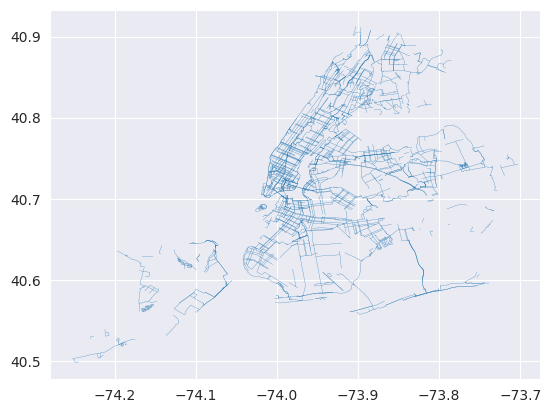

In [11]:
# Visualize the total map of bike lanes in NYC. Note the coordinates: these coordinates will have to be dealt with soon! 
gdf_routes_raw.plot(facecolor='none', linewidth=0.2)

## Preprocessing Step 1a: Selecting Protected Lanes 
As said earlier, This project is chiefly interested in investgating where *protected* bike lanes would be most impactful in abating cyclist injury and mortality in NYC. To this end, we'll: 
1) Create a GeoDataFrame for protected lanes 
2) Create a GeoDataFrame for unprotected lanes 
3) Visualize our protected and unprotected lanes separately

In [12]:
gdf_routes_raw['status'].unique()

array(['Current', 'Retired'], dtype=object)

In [13]:
# Drop NA values from facilitycl , select only current routes 
gdf_routes_raw['facilitycl'] = gdf_routes_raw['facilitycl'].dropna()
gdf_routes_raw = gdf_routes_raw.loc[gdf_routes_raw['status'] == 'Current']
# 2 new GeoDataFrames: one for protected cycle lanes, the other for unprotected lanes. 
# 'allclasses' will be I when the lane is protected, II if conventional, III if signed, and L if marked.
gdf_routes_unprotected = gdf_routes_raw.loc[gdf_routes_raw['facilitycl'] != 'I' ]
gdf_routes_protected = gdf_routes_raw.loc[gdf_routes_raw['facilitycl'] == 'I']

Text(0.5, 1.0, 'Map of protected bike lanes in NYC')

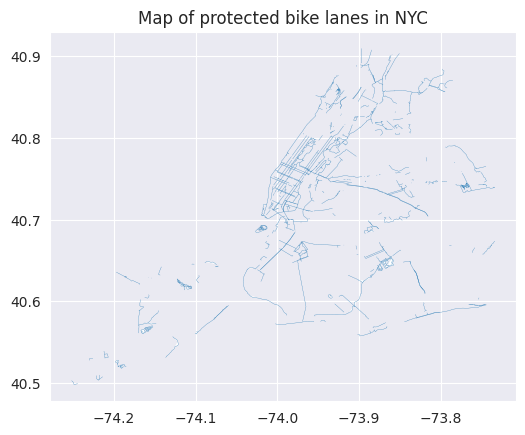

In [14]:
gdf_routes_protected.plot(facecolor='w', linewidth=0.2)
plt.title("Map of protected bike lanes in NYC")

## Preprocessing Step 1b: Getting Geometric Crash Data 
Currently, our crash data is in a pretty unorganized state. We don't have any geometric information that can be worked with in a long format, and our DataFrame has yet to become a GeoDataFrame. Because interoperability between geolocation data is dependent on factors such as coordinate reference system (CRS) and having clean data, I'll proceed to: 
1) Extract the latitude and longitude of each point in the cleaned 'df_crashes' dataframe
2) Transform these points into a GeoSeries (Pandas Series-like) object 
3) Create a new GeoDataFrame to work with our newly-created geometry

### Putting our data together 
To confirm that both the bike lane and crash data have been handled correctly and are ready for the next stage in the data analysis process, visual analysis is very important. To accomplish this, I'll visualize our data in the same Pyplot figure to confirm: 
- Both datasets are in the same CRS
- There are no null/infinite values in the data 
- There are no outlying points in the data which would otherwise complicate further analysis 

In [15]:
# Import geometry library 
from shapely.geometry import Point

# Clean null values from our data 
df_crashes['LONGITUDE'] = df_crashes['LONGITUDE'].dropna()
df_crashes['LATITUDE'] = df_crashes['LATITUDE'].dropna()

# List comprehension to generate our geometry 
geometry = [Point(xy) for xy in zip(df_crashes['LONGITUDE'], df_crashes['LATITUDE'])]
gdf_crashes = gpd.GeoDataFrame(df_crashes, geometry=geometry, crs="EPSG:2263")
gdf_crashes = gdf_crashes.to_crs("EPSG:2263")

# Finally, check our coordinate system
gdf_crashes.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Fatal bike crashes in NYC beneath protected cycle lanes')

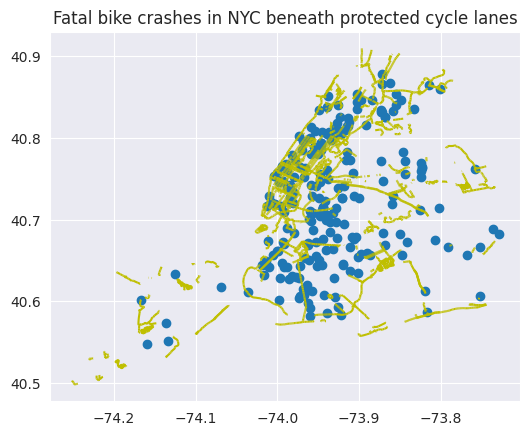

In [16]:
# Remove empty geometry 
gdf_crashes = gdf_crashes[~gdf_crashes.is_empty]

# Remove points at LAT 0.0 LONG 0.0 using a mask
mask = (gdf_crashes.geometry.x == 0.0) & (gdf_crashes.geometry.y == 0.0)
gdf_crashes = gdf_crashes[~mask]

# Create a plot of fatal bike crashes in NYC underlying the locations of protected cycle lanes. 
gdf_crashes.loc[gdf_crashes['NUMBER_CYCLIST_KILLED'] > 0].plot(ax=gdf_routes_protected.plot(color='y'))
plt.title("Fatal bike crashes in NYC beneath protected cycle lanes")

# Feature Engineering: 
I want to know how close each crash was to a protected bike lane, flagging crashes under 200ft from a protected bike lane as "unprotected" crashes. 
I also want to know how many crashes occur in a given area, creating a density metric.

In [17]:
# Function to categorize crash severity
def crash_severity(row):
    if row['NUMBER_CYCLIST_KILLED']> 0:
        return 3
    elif row['NUMBER_CYCLIST_INJURED'] > 0:
        return 2
    else: 
        return 1

# Create a new categorical column.
gdf_crashes['SEVERITY'] = gdf_crashes.apply(crash_severity, axis=1)
gdf_crashes['ZIP_CODE'] = gdf_crashes['ZIP_CODE'].dropna()
gdf_crashes.head()

CRASH_DATE ZIP_CODE   LATITUDE  LONGITUDE  NUMBER_CYCLIST_INJURED  \
3  09/11/2021  11208.0  40.667202 -73.866500                       0   
4  12/14/2021  11233.0  40.683304 -73.917274                       0   
6  12/14/2021      NaN  40.709183 -73.956825                       0   
7  12/14/2021  10475.0  40.868160 -73.831480                       0   
8  12/14/2021  11207.0  40.671720 -73.897100                       0   

   NUMBER_CYCLIST_KILLED                geometry  SEVERITY  
3                      0  POINT (-73.866 40.667)         1  
4                      0  POINT (-73.917 40.683)         1  
6                      0  POINT (-73.957 40.709)         1  
7                      0  POINT (-73.831 40.868)         1  
8                      0  POINT (-73.897 40.672)         1

In [18]:
# Force reprojection to EPSG 4325 (Currently, we have the wrong coordinate system) 
gdf_crashes = gdf_crashes.set_crs("EPSG:4326", allow_override=True) 
gdf_routes_protected = gdf_routes_protected.set_crs("EPSG:4326", allow_override=True)

# Reproject into a coordinate system for our area of interest, with meters of distance 
gdf_crashes = gdf_crashes.to_crs(epsg=32618)
gdf_routes_protected = gdf_routes_protected.to_crs(epsg=32618)

# Perform a spatial join to get distance between the crash and the nearest protected cycle path
gdf_crashes_with_distance = gdf_crashes.sjoin_nearest(
    gdf_routes_protected,
    distance_col='DISTANCE'
)

# Finally, create a column to categorize whether a crash was in the immediate vicinity of a protected bike lane or not
gdf_crashes_with_distance['PROTECTION'] = 1 
gdf_crashes_with_distance.loc[gdf_crashes_with_distance["DISTANCE"] <= 100, 'PROTECTION'] = 0
gdf_crashes_with_distance['PROTECTION'] = gdf_crashes_with_distance['PROTECTION'].fillna(0)

gdf_crashes_with_distance.head()

CRASH_DATE ZIP_CODE   LATITUDE  LONGITUDE  NUMBER_CYCLIST_INJURED  \
3  09/11/2021  11208.0  40.667202 -73.866500                       0   
4  12/14/2021  11233.0  40.683304 -73.917274                       0   
6  12/14/2021      NaN  40.709183 -73.956825                       0   
7  12/14/2021  10475.0  40.868160 -73.831480                       0   
8  12/14/2021  11207.0  40.671720 -73.897100                       0   

   NUMBER_CYCLIST_KILLED                        geometry  SEVERITY  \
3                      0  POINT (595807.916 4502432.021)         1   
4                      0  POINT (591494.198 4504165.347)         1   
6                      0  POINT (588117.833 4506997.658)         1   
7                      0  POINT (598470.878 4524778.813)         1   
8                      0   POINT (593215.14 4502900.648)         1   

   index_right bikedir  ... version onoffst   status      ft_facilit boro  \
3         5951       2  ...     23c      ON  Current        Standard    3   
4         5163       L  ...     23c     OFF  Current            None    3   
6        19243       R  ...     23c     OFF  Current  Protected Path    3   
7        21197       2  ...     23c     OFF  Current        Greenway    2   
8         5608       2  ...     23c      ON  Current  Protected Path    3   

                                street segmentid prevbikeid     DISTANCE  \
3                           LORING AVE   50626.0         NA   280.447256   
4                            LEGION ST   43624.0       1263  1590.463377   
6                         BORINQUEN PL  256689.0         NA   128.148149   
7  HUTCHINSON RIVER GREENWAY EXTENSION  298467.0         NA   669.177342   
8                            POWELL ST   47258.0       None   677.092675   

  PROTECTION  
3          1  
4          1  
6          1  
7          1  
8          1  

[5 rows x 32 columns]

In [19]:
# Finalize our data: 
# Our dataframe to learn on will consist of: geometry, crash date, number of cyclists injured, number of cyclists killed, the severity of the crash, the distance from the crash to the nearest protected bike lane, the borough the crash took place in, and the 'protectedness' of the crash (i.e. whether or not the crash was < 100m from a protected lane). 
gdf_learning = gdf_crashes_with_distance.drop(columns=['LATITUDE', 'LONGITUDE', 'index_right', 'bikedir', 
                                              'fromstreet', 'lanecount', 'facilitycl', 'ft2facilit',
                                              'tostreet', 'ret_date', 'bikeid', 'instdate', 'tf_facilit',
                                              'shape_leng', 'allclasses', 'version', 'status', 'street', 
                                              'segmentid', 'prevbikeid', 'ft_facilit', 'tf2facilit', 'onoffst'])
gdf_learning.sample(10)

CRASH_DATE ZIP_CODE  NUMBER_CYCLIST_INJURED  NUMBER_CYCLIST_KILLED  \
661165   05/05/2018  11693.0                       0                      0   
1348428  04/27/2015  11372.0                       0                      0   
1425524  12/08/2014    10013                       0                      0   
810678   09/01/2017      NaN                       0                      0   
1308061  06/25/2015  10128.0                       0                      0   
534841   11/26/2018  10304.0                       0                      0   
1111901  05/18/2016  10001.0                       0                      0   
84487    11/04/2021  11220.0                       0                      0   
1962946  11/08/2022  10039.0                       0                      0   
227806   08/08/2020  11204.0                       0                      0   

                               geometry  SEVERITY boro     DISTANCE  \
661165   POINT (599904.554 4496087.312)         1    4     6.397066   
1348428  POINT (595075.522 4512370.701)         1    4   207.877067   
1425524  POINT (584214.187 4507836.638)         1    1    84.789006   
810678   POINT (603538.586 4501872.882)         1    4  1191.263175   
1308061   POINT (589041.232 4515231.61)         1    1     0.068039   
534841   POINT (577648.868 4497408.713)         1    5  1235.950389   
1111901  POINT (585168.393 4511529.975)         1    1   234.307009   
84487    POINT (583363.186 4500176.836)         1    3   211.166941   
1962946  POINT (589742.967 4521125.766)         1    1    77.248788   
227806   POINT (584687.796 4496723.559)         1    3  1966.542472   

         PROTECTION  
661165            0  
1348428           1  
1425524           0  
810678            1  
1308061           0  
534841            1  
1111901           1  
84487             1  
1962946           0  
227806            1

## Data Validation 
- Some of our features (e.g. location and borough, distance and protectedness, number of cyclists injured/killed and severity) could be collinear. Let's see the influence of this collinearity on the data.


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
                        NUMBER_CYCLIST_INJURED  NUMBER_CYCLIST_KILLED  \
NUMBER_CYCLIST_INJURED                1.000000               0.002384   
NUMBER_CYCLIST_KILLED                 0.002384               1.000000   
SEVERITY                              0.985965               0.128327   
DISTANCE                             -0.001473              -0.000103   
PROTECTION                           -0.019825              -0.001349   

                        SEVERITY  DISTANCE  PROTECTION  
NUMBER_CYCLIST_INJURED  0.985965 -0.001473   -0.019825  
NUMBER_CYCLIST_KILLED   0.128327 -0.000103   -0.001349  
SEVERITY                1.000000 -0.001482   -0.019913  
DISTANCE               -0.001482  1.000000    0.008407  
PROTECTION             -0.019913  0.008407    1.000000  


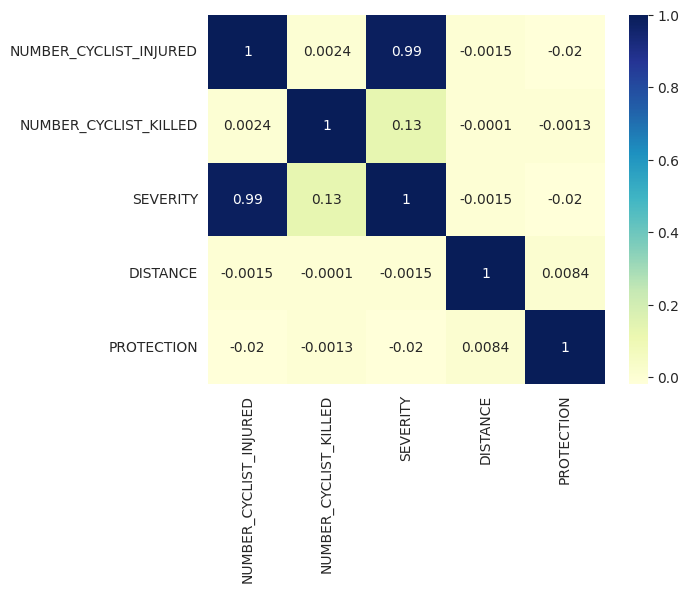

In [20]:
# Install seaborn and import it, if not already installed 
!pip install seaborn
import seaborn as sns 

# Make a correlation matrix to test for any collinearity. 
# What I want to know: Should I remove NUM_CYCLIST_KILLED/NUM_CYCLIST_INJURED due to multicollinearity?  
corr_matrix = gdf_learning.corr(numeric_only=True) 
print(corr_matrix)

sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True)
plt.show()

From this correlation matrix, NUMBER_CYCLIST_INJURED is highly collinear with SEVERITY (0.99). Because SEVERITY should already capture the impact of cyclist injuries and fatalities, we can drop both columns

In [21]:
# remove NUMBER_CYCLIST_INJURED
gdf_learning = gdf_learning.drop(columns=['NUMBER_CYCLIST_INJURED', 'NUMBER_CYCLIST_KILLED'])

In [22]:
# Install folium if it doesn't already exist
!pip install folium
import folium 
from folium.plugins import HeatMap 

# Reproject to geographic CRS 
gdf_learning = gdf_learning.to_crs(epsg=4326)
gdf_routes_protected = gdf_routes_protected.to_crs(epsg=4326)

# Center geometry
latitude = gdf_learning.geometry.y.mean()
longitude = gdf_learning.geometry.x.mean() 

# Sanity check: see if geometry center makes sense for our data
print(f"Map center: Latitude = {latitude}, Longitude = {longitude}")

# Create a heatmap with folium to take a look at where severe crashes are most numerous
m = folium.Map(location=[latitude, longitude], zoom_start = 12)
heat_data = [(point.xy[1][0], point.xy[0][0]) for point in gdf_learning.loc[gdf_learning['SEVERITY'] > 2].geometry]
HeatMap(heat_data).add_to(m)
folium.GeoJson(gdf_routes_protected.geometry).add_to(m)
m


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Map center: Latitude = 40.72255112654289, Longitude = -73.90515916893598


In [23]:
m.save(outfile='heatmap.html')

In [24]:
# Use dissolve to spatially aggregate data by zip code for clustering with DBSCAN
gdf_agg = gdf_learning.dissolve(by='ZIP_CODE', 
                                aggfunc={
                                    "SEVERITY": "max", 
                                    "boro": "first", 
                                    "PROTECTION": "max", 
                                    "CRASH_DATE": "first",
                                    "DISTANCE": "mean"
                                })
# Don't use geographic CRS
gdf_agg = gdf_agg.to_crs(epsg="2263")
gdf_agg.head()

geometry  SEVERITY boro  \
ZIP_CODE                                                                     
10000.0   MULTIPOINT (990504.283 220369.692, 991260.113 ...         2    1   
10001.0   MULTIPOINT (981947.548 212767.92, 982051.485 2...         3    1   
10002.0   MULTIPOINT (954465.863 170537.317, 981043.042 ...         3    1   
10003.0   MULTIPOINT (985086.994 205747.881, 985088.989 ...         3    1   
10004.0   MULTIPOINT (979500.522 196060.052, 979534.973 ...         2    1   

          PROTECTION  CRASH_DATE    DISTANCE  
ZIP_CODE                                      
10000.0            1  04/18/2021  105.505324  
10001.0            1  12/11/2021   71.500520  
10002.0            1  03/26/2022   53.669730  
10003.0            1  09/11/2021   61.116154  
10004.0            1  04/20/2021   71.228911

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from shapely.geometry import MultiPoint 

# Use MinMax scaling to create an 'impact' column. 
scaler = MinMaxScaler() 
gdf_agg['impact'] = 0.7*scaler.fit_transform(gdf_agg[['SEVERITY']]) + 0.3*scaler.fit_transform(gdf_agg[["DISTANCE"]])

# Use centroids to scale our data. 
x = np.array(list(gdf_agg.geometry.centroid.x))
y = np.array(list(gdf_agg.geometry.centroid.y)) 

# Create dataframe to further process 
data = {"x": x, "y": y, "impact": gdf_agg["impact"]} 
X = pd.DataFrame(data=data)

# Fit and transform our data
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 

In [26]:
# Sanity check: reproject to non-geometric CRS 
gdf_agg = gdf_agg.to_crs(epsg=2263)
gdf_agg.head()

geometry  SEVERITY boro  \
ZIP_CODE                                                                     
10000.0   MULTIPOINT (990504.283 220369.692, 991260.113 ...         2    1   
10001.0   MULTIPOINT (981947.548 212767.92, 982051.485 2...         3    1   
10002.0   MULTIPOINT (954465.863 170537.317, 981043.042 ...         3    1   
10003.0   MULTIPOINT (985086.994 205747.881, 985088.989 ...         3    1   
10004.0   MULTIPOINT (979500.522 196060.052, 979534.973 ...         2    1   

          PROTECTION  CRASH_DATE    DISTANCE    impact  
ZIP_CODE                                                
10000.0            1  04/18/2021  105.505324  0.360146  
10001.0            1  12/11/2021   71.500520  0.706872  
10002.0            1  03/26/2022   53.669730  0.705156  
10003.0            1  09/11/2021   61.116154  0.705873  
10004.0            1  04/20/2021   71.228911  0.356846

## Unsupervised Learning 
Our data is now cleaned with useful feature engineering and validated to not be multicollinear. Now, we can begin the unsupervised learning portion of the analysis. As a jumping-off point, I'll be using DBSCAN clustering to highlight any relevant clusters of crashes. DBSCAN was selected for its ability to identify clusters in the data based on density. This might point towards a cycling corridor where protected cycling lanes would be maximally impactful!

In [27]:
# Run DBSCAN 
dbscan = DBSCAN(eps=0.222, min_samples=2) # params to start 
gdf_agg['cluster'] = dbscan.fit_predict(X_scaled) 

# validate clusters. values of -1 are invalid 
valid_clusters = gdf_agg[gdf_agg['cluster'] != -1] 

# mean impact score per cluster 
cluster_scores = valid_clusters.groupby('cluster')['impact'].mean().sort_values(ascending=False) 

# Select top 10 clusters with the highest impact scores 
top_clusters = cluster_scores.head(10).index 
impact_cluster_data = valid_clusters[valid_clusters['cluster'].isin(top_clusters)] 

# Use centroids for geometric computation and take a look: 
impact_cluster_data.geometry = impact_cluster_data.centroid
impact_cluster_data

/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


geometry  SEVERITY boro  PROTECTION  \
ZIP_CODE                                                              
10027.0    POINT (997851.592 234641.585)         3    1           1   
11206.0   POINT (1000181.358 195114.895)         3    3           1   
11213.0   POINT (1002000.917 183573.348)         3    3           1   
11216.0    POINT (998463.093 187449.384)         3    3           1   
11218.0    POINT (990877.039 173131.887)         3    3           1   
11220.0    POINT (980414.063 172480.869)         3    3           1   
11223.0    POINT (992041.768 157597.255)         3    3           1   
11232.0    POINT (983439.951 177837.849)         3    3           1   
11238.0    POINT (994244.263 187458.014)         3    3           1   
11354.0   POINT (1032096.967 218469.944)         3    4           1   
11355.0   POINT (1033196.995 213384.326)         3    4           1   
11417.0   POINT (1027460.532 186062.943)         3    4           1   
11434.0   POINT (1046390.042 185500.292)         3    4           1   
10027       POINT (997429.63 235034.774)         3    1           1   
11205      POINT (994592.289 192275.302)         3    3           1   
11206      POINT (1000307.058 195190.28)         3    3           1   
11218      POINT (990660.444 173786.523)         3    3           1   
11223       POINT (991818.608 157108.54)         3    3           1   
11225      POINT (997069.857 180683.025)         3    3           1   
11238      POINT (994328.491 187341.446)         3    3           1   
11354     POINT (1032618.851 218976.955)         3    4           1   
11416     POINT (1025840.288 188629.344)         3    4           1   
11436     POINT (1040782.402 185528.205)         3    4           1   

          CRASH_DATE     DISTANCE    impact  cluster  
ZIP_CODE                                              
10027.0   12/10/2021   666.475812  0.764148        3  
11206.0   03/26/2022   785.195088  0.775577       28  
11213.0   12/04/2021   427.128307  0.741107       32  
11216.0   04/14/2021  1066.020732  0.802611       34  
11218.0   12/09/2021   346.415846  0.733337       35  
11220.0   04/24/2022   356.819317  0.734339       36  
11223.0   12/09/2021   550.102391  0.752946       37  
11232.0   04/14/2021   299.691532  0.728839       36  
11238.0   03/10/2022   765.558891  0.773687       34  
11354.0   03/23/2022   741.549388  0.771376       44  
11355.0   04/17/2021   679.198719  0.765373       44  
11417.0   04/15/2021  1629.645007  0.856869       63  
11434.0   12/14/2021  1245.334596  0.819873       73  
10027     03/08/2015   639.474329  0.761549        3  
11205     02/28/2015   665.197852  0.764025       34  
11206     03/19/2015   781.361245  0.775208       28  
11218     03/21/2015   344.083329  0.733113       35  
11223     03/05/2015   527.106283  0.750732       37  
11225     03/09/2015   481.953407  0.746385       32  
11238     03/20/2015   766.718555  0.773798       34  
11354     03/18/2015   737.675142  0.771003       44  
11416     03/11/2015  1528.651498  0.847147       63  
11436     03/09/2015  1200.485465  0.815556       73

In [35]:
# Create hulls to visualize 
hulls = [] 
for cluster_id in top_clusters: 
    cluster_points = impact_cluster_data[impact_cluster_data['cluster'] == cluster_id].geometry.explode()
    hull = MultiPoint(cluster_points.tolist()).convex_hull 
    hulls.append(hull)

# Make GDF w/ recc'd areas 
recc_areas = gpd.GeoDataFrame(geometry=hulls, crs=gdf_learning.crs) 

# Take a look:
recc_areas

geometry
0  LINESTRING (1027460.532 186062.943, 1025840.28...
1  LINESTRING (1046390.042 185500.292, 1040782.40...
2  POLYGON ((994328.491 187341.446, 994244.263 18...
3  LINESTRING (1000181.358 195114.895, 1000307.05...
4  POLYGON ((1033196.995 213384.326, 1032096.967 ...
5  LINESTRING (997851.592 234641.585, 997429.63 2...
6  LINESTRING (992041.768 157597.255, 991818.608 ...
7  LINESTRING (1002000.917 183573.348, 997069.857...
8  LINESTRING (990877.039 173131.887, 990660.444 ...
9  LINESTRING (980414.063 172480.869, 983439.951 ...

In [36]:
# Reproject for mapping
recc_areas = recc_areas.to_crs(epsg=2263)
gdf_routes_protected = gdf_routes_protected.to_crs(epsg=2263)

In [39]:
mp = folium.Map(location=[latitude, longitude], zoom_start = 12)
folium.GeoJson(gdf_routes_protected.geometry).add_to(mp)
folium.GeoJson(recc_areas.geometry, style_function= lambda feature:{
    'fillColor': 'green', 
    'color': 'darkgreen',
    'weight': 2, 
    'fillOpacity': 0.5
}).add_to(mp)
mp

In [40]:
mp.save(outfile='map.html')

# Conclusions 
We've correctly preprocessed our data, engineered features encoding crash severity and possible impact of a new protected bike lane, ran a DBSCAN clustering model, and plotted the most impactful areas for protected bike lanes. 

These areas represent places where protected bike lanes would be the most important in reducing city-wide cyclist injuries and fatalities. Interestingly, many of these high-impact areas would function as connectors between protected cycling lanes, which might suggest that abrupt breaks in protected cycling infrastructure (coupled with high vehicle traffic areas) could be associated with much higher cyclist injuries and fatalities. 

Our recommended areas to connect protected cycling areas would be:
- Between Flushing Avenue/Williamsburg Street West and Atlantic Avenue/Clinton-Washington Avenues in Clinton Hill, Brooklyn
    - The recommended area in Clinton Hill was particularly large, suggesting that more connections and protected cycle infrastructure in general would lead to much higher benefits for cyclists.
- Between Roosevelt Avenue/College Point Blvd. and Northern Blvd./Parsons Blvd. in Flushing, Queens
- Between 97th Avenue/91st Street and Sutter Avenue/Cross Bay Blvd. in Ozone Park, Brooklyn 
- Between 123rd Avenue/Linden Avenue and Rochdale Village in Jamaica, Queens 
- Between Dahill Road/Fort Hamilton Pkwy. and Ocean Pkwy./Church Avenue in Flatbush, Brooklyn
- Between 60th Street/5th Avenue and 34th Street/5th Avenue in Sunset Park, Brooklyn
- Between Grand Street/Bushwick Avenue and Morgan Avenue/Johnson Avenue in Bushwick, Brooklyn